# Creation of Synthetic Images
## approach
- Load a background
- Apply random transformation

- Load a box picture
- Apply random transformation
- Copy to background
- Save

## Random Transformation for Background
- flip horyzontal
- stretch/shear
- light
- zoom

## Random Transformation for Box
- flip horyzontal
- flip vertical
- stretch
- light
- zoom
- some rotation
- at the end : crop bottom

use augment API

In [1]:
#!pip install opencv-python

In [48]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import time
from skimage.util import random_noise    
from skimage.draw import random_shapes

OB = 1    # openBox
CB = 0    # Clsoed Box

def imshow(line, col, title, image):
    print('ndim = ', image.shape)
    print (len(image.shape))
    if  len(image.shape) ==2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif  image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif  image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
    ax[line, col].imshow(image)
    ax[line, col].set_title(title)
    
def plot(line, col, title, xAxis, yAxis):
    ax[line, col].plot(xAxis, yAxis)
    ax[line, col].set_title(title)

def boolrand():
    return (random.randint(0,1))


def insertmask(x,y,bkg_mask, fgd_mask):
    (hf, wf) = fgd_mask.shape[:2]
    (hb, wb) = bkg_mask.shape[:2]

    # Check size of foreground; crop if needed
    # On the right
    if (x + wf > wb) :   
        fgd_mask = fgd_mask[:,0:wb-x]
        (hf, wf) = fgd_mask.shape[:2]
    # On the bottom
    if (y + hf > wb) :    
        fgd_mask = fgd_mask[0:hb,:]
        (hf, wf) = fgd_mask.shape[:2]
    # On the left
    if (x <0) :   
        fgd_mask = fgd_mask[:,-x:wf]
        (hf, wf) = fgd_mask.shape[:2]
        x=0
        
    (hf, wf) = fgd_mask.shape[:2]

    # We insert the foreground only if it fits within the background
    if (x+wf<=wb) and (y+hf<=hb) and wf>20:
        bkg_mask[y:y+hf, x:x+wf] = 255
        
    return bkg_mask, x, y , wf, hf

def insertimg(x,y,bkg_img, fgd_img):
    (hf, wf) = fgd_img.shape[:2]
    (hb, wb) = bkg_img.shape[:2]

    # Check size of foreground; crop if needed
    # On the right
    if (x + wf > wb) :   
        fgd_img = fgd_img[:,0:wb-x]
        (hf, wf) = fgd_img.shape[:2]
    # On the bottom
    if (y + hf > wb) :    
        fgd_img = fgd_img[0:hb,:]
        (hf, wf) = fgd_img.shape[:2]
    # On the left
    if (x <0) :     
        fgd_img = fgd_img[:,-x:wf]  
        (hf, wf) = fgd_img.shape[:2]
        x=0
    
    
    # We insert the foreground only if it fits within the background
    if (x+wf<=wb) and (y+hf<=hb) and wf>20:
        alpha_s = fgd_img[:, :, 3] / 255.0
        alpha_l = 1.0 - alpha_s

        for c in range(0, 3):
            bkg_img[y:y+hf, x:x+wf, c] = (alpha_s * fgd_img[:, :, c] +
                                      alpha_l * bkg_img[y:y+hf, x:x+wf, c])
    return bkg_img

# Load all Racks and boxes
output : arrBoxes

In [49]:
#PARAMETERS
SizeBKG = (416,416)
resize = 0.185   # ratio for resizing boxes

#Read all boxes
base_dir_box = 'Box_extract'
arrBoxes = []
files = os.listdir(base_dir_box)
files.sort()
NbOfBoxes = len(files)
print ('Number of Boxes found = ', NbOfBoxes)
i=0
for f in files:
    filepath = os.path.join(base_dir_box,f)
    print(filepath)
#     img = load_img(filepath, grayscale=True, target_size=(h,w))  #gray scale
    img = cv2.imread(filepath,-1)
    img = cv2.resize(img, None, fx=resize, fy=resize)
    arrBoxes.append(img)
#print(arrBoxes.shape)

#Read all Racks (Background)
base_dir_bkg = 'Racks'
bkg_files = os.listdir(base_dir_bkg)
arrBkg = []
NbOfBkg = len(bkg_files)
print ('Number of Racks found = ', NbOfBkg)
i=0
for f in bkg_files:
    filepath = os.path.join(base_dir_bkg,f)
#     img = load_img(filepath, grayscale=True, target_size=(h,w))  #gray scale
    img = cv2.imread(filepath,-1)
    img = cv2.resize(img, (SizeBKG))
    arrBkg.append(img)
print(arrBkg[0].shape)

Number of Boxes found =  23
Box_extract/0.Box.1.png
Box_extract/0.Box.10.png
Box_extract/0.Box.11.png
Box_extract/0.Box.12.png
Box_extract/0.Box.2.png
Box_extract/0.Box.3.png
Box_extract/0.Box.4.png
Box_extract/0.Box.5.png
Box_extract/0.Box.6.png
Box_extract/0.Box.7.png
Box_extract/0.Box.8.png
Box_extract/0.Box.9.png
Box_extract/1.Box.13.png
Box_extract/1.Box.14.png
Box_extract/1.Box.15.png
Box_extract/1.Box.16.png
Box_extract/1.Box.17.png
Box_extract/1.Box.18.png
Box_extract/1.Box.19.png
Box_extract/1.Box.20.png
Box_extract/1.Box.21.png
Box_extract/1.Box.22.png
Box_extract/1.Box.23.png
Number of Racks found =  47
(416, 416, 3)


# Box transformation
- Boxes are already in png format, ie BGRA, ie with ALPHA channel
- the box image is inscreased without changing the box as such. This leaves room for performing rotation without the rotation cropping the box. 
- Then Several transformations are performed
    - 2 to 12 random reflections are added, being randomly a white or black rectangle overlaid to the box
    - rotation between -5° and +5°
    - flip around axis
    - resize
    
- after that contour detection is carried out to determine the position of the box. we identify the box image and the mask
- DEACTIVATED : a random vertical crop is carried out on the box and the mask

ndim =  (50, 37, 4)
3
ndim =  (22, 30, 4)
3
ndim =  (22, 30)
2


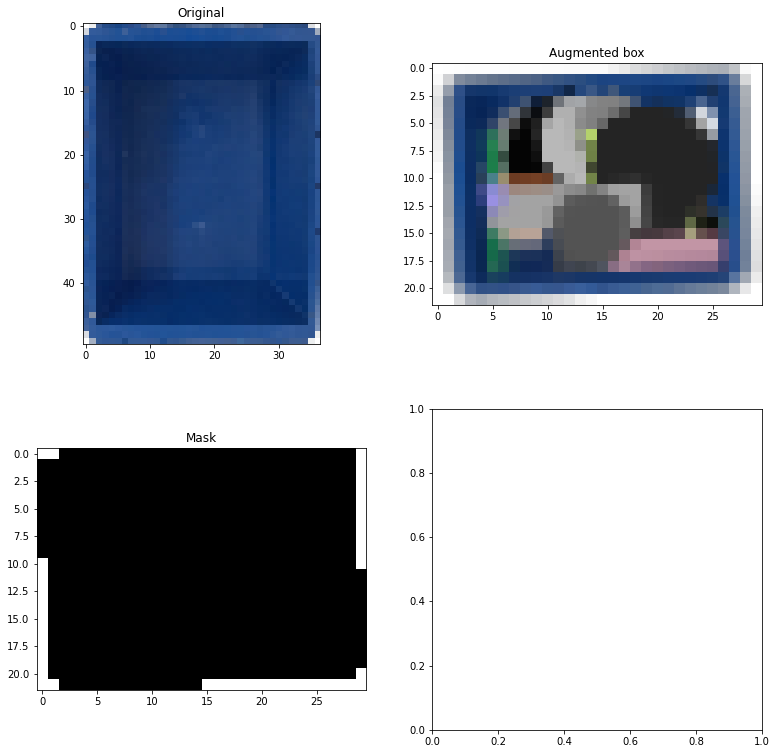

In [50]:
Aug_Rotation = True
Aug_Flip = True
Aug_Resize = True
Aug_Rot_90 = True
Crop = False   # We use overlap instead   

def augmentBox(box, boxType):

    (hBox, wBox) = box.shape[:2]
    
    # Creation of random shapes
    if boxType==OB and random.randint(0,100)<80 :    # we foill the boxes 80% of the time
        xmin = int(wBox * 0.1)
        xmax = int(wBox * 0.9)
        ymin = int(hBox * 0.1)
        ymax = int(hBox * 0.9)
        for shape in range(random.randint(3,50)):
            color = (random.randint(0,255),random.randint(0,255),random.randint(0,255),random.randint(100,255))
            x1 = random.randint(xmin, xmax)
            y1 = random.randint(ymin, ymax)
            x2 = random.randint(xmin, xmax)
            y2 = random.randint(ymin, ymax)
            B = random.randint(0,255)
            G = random.randint(0,255)
            R = random.randint(0,255)
            Alpha = random.randint(100,255)
            if random.randint(0,100)<20:    # gray box 80% of the time
                color = (B, G, R, Alpha)
            else:
                color = (B, B, B, 255)     
            
            if boolrand():
                cv2.rectangle(box,(x1,y1),(x2,y2),color= color, thickness=-1)    # color  (B,G,R,Alpha)
            else:
                radius = min(x1-xmin, xmax -x1, y1-ymin, ymax-y1)
                cv2.circle(box, (x1,y1), radius, color = color, thickness = -1)
    
    # DEACTIVATED Creation of overlays to simulate saheds and reflexions. only for Open boxes
    if boxType==10:
        b_channel, g_channel, r_channel, alpha_channel_save = cv2.split(box)
        boxBGR = cv2.cvtColor(box, cv2.COLOR_BGRA2BGR)
        boxHSL = cv2.cvtColor(boxBGR, cv2.COLOR_BGR2HLS)

        wMax = int(wBox*1)
        hMax = int(hBox*1)
        for i in range (0, random.randint(2,12)):
            glare = random.randint(-50,150)
            x1 = random.randint(0, int(wBox * 0.70))
            y1 = random.randint(0, int(hBox * 0.70))
            wGlare = random.randint(10,int(wBox-x1))
            hGlare = random.randint(10,int(hBox-y1))
            whiteBox = box[y1:y1+hGlare, x1:x1+wGlare]
            if boolrand():
                whiteBox = 255
            else:
                whiteBox = 0
    #         boxHSL[y1:y1+hGlare, x1:x1+wGlare,0] = 255# np.where(box[y1:y1+hGlare, x1:x1+wGlare,0]+glare<255,box[y1:y1+hGlare, x1:x1+wGlare,0]+glare,255)
    #         boxHSL[y1:y1+hGlare, x1:x1+wGlare,1] = 255# np.where(box[y1:y1+hGlare, x1:x1+wGlare,1]+glare<255,box[y1:y1+hGlare, x1:x1+wGlare,1]+glare,255)
            boxHSL[y1:y1+hGlare, x1:x1+wGlare,1] =  cv2.add(box[y1:y1+hGlare, x1:x1+wGlare,1],glare)

        boxBGR = cv2.cvtColor(boxHSL, cv2.COLOR_HLS2BGR)
        b_channel, g_channel, r_channel = cv2.split(boxBGR)
        box = cv2.merge((b_channel, g_channel, r_channel, alpha_channel_save)) 
    
#     b_channel, g_channel, r_channel, alpha_channel = cv2.split(box)
#     b_channel = np.where(b_channel+100<255, b_channel+100, 255)
#     g_channel = np.where(g_channel+100<255, g_channel+100, 255)
#     r_channel = np.where(r_channel+100<255, r_channel+100, 255)
#     box = cv2.merge((b_channel, g_channel, r_channel, alpha_channel)) 
    
    # Creation of a bigger picture with transparent background to allow rotation without cropping
    newbox = cv2.resize(box, None, fx=2, fy=2)    
    (hnBox, wnBox) = newbox.shape[:2]
    (hBox, wBox) = box.shape[:2]
#     print("newbox.shape = ", newbox.shape)
    b_channel, g_channel, r_channel, alpha_channel = cv2.split(newbox)
    b_channel[:,:] = g_channel[:,:] =  r_channel[:,:] = 0
    alpha_channel[:,:] = 0     # transparent
    newbox = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    y1 = hnBox//2 - hBox//2   # we put the box picture in the middle of the newbox
#     y2 = hnBox//2 + hBox//2
    x1 = wnBox//2 - wBox//2
#     x2 = wnBox//2 + wBox//2
    newbox[y1:y1+hBox, x1:x1+wBox] = box
    box = newbox

    # Flip : all possibilities
    if Aug_Flip:
        if boolrand():
            mode = random.randint(-1,1)
            box = cv2.flip(box,mode)
            (hBox, wBox) = box.shape[:2]

    # scale : -90% to 0
    if Aug_Resize:
        rate = random.randint(-50,0)/100
        box = cv2.resize(box, None, fx = 1 + rate, fy = 1+ rate)
        (hBox, wBox) = box.shape[:2]

    # rotation : from -5° to 5°
    if Aug_Rotation:
        rotation = random.randint(-5,5)
        M = cv2.getRotationMatrix2D((wBox/2,hBox/2),rotation,1)
        box = cv2.warpAffine(box,M,(wBox, hBox))
        (hBox, wBox) = box.shape[:2]

   
    # rotation 90°
    if Aug_Rot_90:
        if boolrand():
            rotation = 90
            M = cv2.getRotationMatrix2D((wBox/2,hBox/2),rotation,1)
            box = cv2.warpAffine(box,M,(wBox, hBox))
            (hBox, wBox) = box.shape[:2]
    
    
    # Extract mask , box and bounding box
    mask =  np.zeros(box.shape)   #mask out of HSV selection. there may be gaps in the selection (eroded contour, ...)
    lower = np.array([0,0,0,0])
    upper = np.array([255,255,255,1])
    mask = cv2.inRange(box, lower, upper)
    contours, hierarchy = cv2.findContours(~mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    peri = cv2.arcLength(contours[0], True)
    corners = cv2.approxPolyDP(contours[0], 0.002 * peri, True)    # small threshold to make sure that the bounding bow really takes everything
    objCorner = len(corners)
    x, y, w, h = cv2.boundingRect(corners)
#     print("x, y, w, h ", x, y, w, h  )
    # cv2.rectangle(mask, (x, y), (x + w, y + h), (0,0, 0), 5)

    # Crop 
    if Crop and boolrand():
            cropvalue = random.randint(5,100)/100
            box = box[y:y+int(h*cropvalue), x:x+w]
            mask = mask[y:y+int(h*cropvalue), x:x+w]
    else:
        box = box[y:y+h, x:x+w]
        mask = mask[y:y+h, x:x+w]
    
    
 
    
    return box, mask
    
# Test Augmentation Box
boxId = 1
fig, ax = plt.subplots(2,2,figsize=(13, 13))
box,mask = augmentBox(cv2.resize(arrBoxes[boxId],None, fx=1,fy=1),boxType= OB)    

imshow(0,0,"Original",arrBoxes[boxId])
imshow(0,1,"Augmented box", box)
imshow(1,0,"Mask", mask)
plt.show()

In [51]:
# Values (anchors) for shelves in the 4 racks we have as images
arrShelves = []
# arrSelves.append([yShelf1, yS1maxHeight, yShelf2, yS2maxHeight, OffsetShelf2])    OffsetShelf2 = used to randomly create an overlapping with first row


Xoverlap=False
Yoverlap=True
def createImage():
    xOffset = 10
    
    
    
    idx = random.randint(0,NbOfBkg-1)
    Bkg = arrBkg[idx]
    if boolrand():
        Bkg = cv2.flip(Bkg,random.choice([-1,0,1]))
    
    resultMask = Bkg.copy()
    result = Bkg.copy()
    resultMask[:] = 0
    (hBkg, wBkg) = Bkg.shape[:2]
    listObj = []  # this will contain type of Box  + x, y, w h for each mask of the final picture

 
    
    xInsert = random.randint(0,100 )
    yInsert = random.randint(0,100 )
    wPrevBox = 0
    hPrevBox = 0
    space = True
    boxNumber =0
    while space:
        x_overlap = 0
        y_overlap = 0
        if random.randint(0,100) > 20:    # 80% of the time we pick randomly an open box
            boxId = random.randint(0,11)  # open Box
            objType = OB
        else:
            boxId = random.randint(12,22) # Closed Box
            objType = CB


        box,mask = augmentBox(cv2.resize(arrBoxes[boxId],None, fx=1,fy=1),objType)
        (hBox, wBox) = box.shape[:2]
                                             
        # To manage overlap of the current box on the previous one, we need to change the boundingbox of the previous box
        if boolrand(): #Horizontally
            if Xoverlap and boolrand() and wPrevBox>30:             # Set 50% likelyhood overlapping, with random overlap on previous box
                x_overlap = random.randint(int(wPrevBox *0.1), min(int(wPrevBox *0.5), wBox-10))
            xInsert = xInsert + wPrevBox - x_overlap
            yInsert = yInsert
        else:              #Or vertically
            if Yoverlap and boolrand() and hPrevBox>30:             # Set 50% likelyhood overlapping, with random overlap on previous box
                y_overlap = random.randint(int(hPrevBox *0.1), min(int(hPrevBox *0.8),hBox-10))
            xInsert = xInsert
            yInsert = yInsert + hPrevBox - y_overlap


        # if the new box fits into the background, then we insert the image and mask
        if (xInsert+wBox < wBkg) & (yInsert + hBox < hBkg):
            # We adjust the last bounding box in case of overlap
            
            if boxNumber >0:
                preBoxNumber = boxNumber-1
                # Adjust Width  
#                 if x_overlap > 0 and hBox > hPrevBox:
                listObj[preBoxNumber][3] = listObj[preBoxNumber][3] - x_overlap
#                 if y_overlap > 0 and wBox > wPrevBox:
                listObj[preBoxNumber][4] = listObj[preBoxNumber][4] - y_overlap
                
            result = insertimg(xInsert,yInsert, result, box )
            resultMask, xInsert, yInsert, wBox, hBox = insertmask(xInsert,yInsert, resultMask, mask )
            listObj.append([objType, xInsert, yInsert, wBox, hBox])
            (hPrevBox, wPrevBox) = box.shape[:2]
            boxNumber +=1
        else:
            space = False
        # else we do nothing, we don't add the box, we skip this iteration
            
    return result, resultMask, listObj

0 / 1100  images generated
There are 19 boxes
type , x, y, w, h 1 62 31 35 46
type , x, y, w, h 1 62 77 26 33
type , x, y, w, h 1 88 77 30 39
type , x, y, w, h 1 118 77 34 26
type , x, y, w, h 1 118 103 21 28
type , x, y, w, h 1 139 103 37 47
type , x, y, w, h 1 176 103 30 23
type , x, y, w, h 1 206 103 48 29
type , x, y, w, h 0 206 132 40 32
type , x, y, w, h 1 246 132 37 43
type , x, y, w, h 0 246 175 40 24
type , x, y, w, h 1 246 199 31 33
type , x, y, w, h 1 246 232 38 49
type , x, y, w, h 1 284 232 32 41
type , x, y, w, h 0 284 273 47 36
type , x, y, w, h 0 331 273 34 43
type , x, y, w, h 0 365 273 46 26
type , x, y, w, h 1 365 299 44 29
type , x, y, w, h 0 365 328 22 29
10 / 1100  images generated
20 / 1100  images generated
30 / 1100  images generated
40 / 1100  images generated
50 / 1100  images generated
60 / 1100  images generated
70 / 1100  images generated
80 / 1100  images generated
90 / 1100  images generated
100 / 1100  images generated
110 / 1100  images generated
120 /

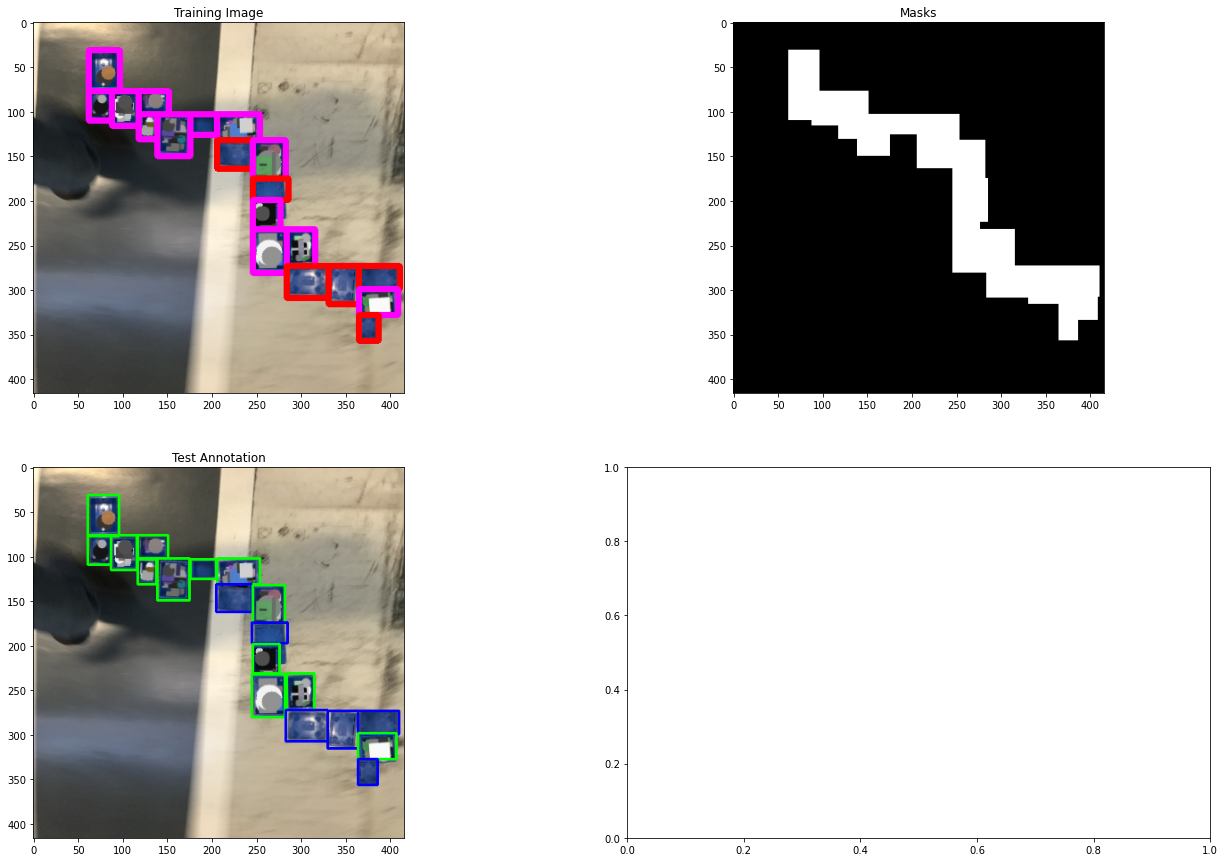

In [52]:
writeToDisk = True
mode = "temp"    # values : temp, val, train
numberOfImages = 1100

fig, ax = plt.subplots(2,2,figsize=(23, 15))

nbOfDec = 6    # nb of decimals in annotation

base_dir_train = 'train'
base_dir_test = 'val'
base_dir_temp = 'temp'
if mode == "temp":
    base_dir_save = base_dir_temp
if mode == "val":
    base_dir_save = base_dir_test
if mode == "train":
    base_dir_save = base_dir_train

img_count = 0
annotation = 'filename,width,height,class,xmin,ymin,xmax,ymax\n'
for img_count in range(numberOfImages):
    file1 = open(os.path.join("labels", base_dir_save, "pic.{}.txt".format(img_count)),"w") 
    if img_count%10==0:
        print (img_count, "/", numberOfImages, " images generated")
    
    train_image,train_mask, listMasks = createImage()
    hBkg, wBkg = train_image.shape[:2]

    """       
    # Change luminosity  
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2HLS)
    increase = random.randint(-50,50)
    train_image[:, :, 1]  = cv2.add(train_image[:, :, 1] ,increase)
    train_image = cv2.cvtColor(train_image, cv2.COLOR_HLS2BGR)
    
    # Adding of global shadows, one on top, one on bottom
    # Polygons corners defined using y = ax+b
    # List polygon points are (x,y), listed clockwise
    
    for i in range (0,2):
        shadow_intensity = random.randint(15,40)/100 
        # Shadow on top
        a=random.choice([-1,1]) * random.random()
        b=random.randint(0,int(hBkg/2))
        y = int(a*wBkg+b) # y = ax+b
        pts = np.array([[[0,0],[hBkg-1,0],[hBkg,y],[0,b]]], np.int32)
        shadow = train_image.copy()
        cv2.fillPoly(shadow,[pts],(0,0,0))
        train_image = cv2.addWeighted(shadow,0.25,train_image,0.75,0)

    # Shadow on bottom
    for i in range(0,2):
        shadow_intensity = random.randint(15,40)/100 
        a=random.choice([-1,1]) * random.random()   # Slope
        b=random.randint(int(hBkg/2),hBkg-10)          # Offset
        y = int(a*wBkg+b)
        pts = np.array([[[wBkg-1,y],[wBkg, hBkg],[0,hBkg-1], [0,b]]], np.int32) 
        shadow = train_image.copy()
        cv2.fillPoly(shadow,[pts],(0,0,0))
        train_image = cv2.addWeighted(shadow,0.25,train_image,0.75,0)
    """
    
    # Adding noise to picture 50% prob
    if boolrand() and False:
        noise = random.choice(['s&p','poisson','gaussian'])
        train_image = random_noise(train_image, mode=noise)    # s&p with amount = 0.011,   gaussian,   poisson

        # The above function returns a floating-point image in the range [0, 1]
        # so need to change it to 'uint8' with range [0,255]
        train_image = np.array(255 * train_image, dtype=np.uint8)
   
    #make the image B&W for 20% of the images
    #if random.randint(0,100)>80:
    #    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        
    if img_count==0 :
        train_image_ex = train_image.copy()
        train_mask_ex = train_mask.copy()
        print("There are",len(listMasks),"boxes")
    
    # Creation of the annotation
    for m in listMasks:
        maskType = m[0]
        x = m[1]
        y = m[2]
        w = m[3]
        h = m[4]
        if maskType== CB:
            maskTypeName = 'ClosedBox'
        else:
            maskTypeName = "OpenBox"
        
        annotation = str(maskType) + " " + str(round((x + w/2)/wBkg,nbOfDec)) + " " + str(round((y+h/2)/hBkg,nbOfDec)) + " " + str(round(w/wBkg, nbOfDec)) + " "  + str(round(h/hBkg, nbOfDec)) + "\n"
        if writeToDisk:
            file1.write(annotation) 
#        annotation +=  "pic.{}.jpg".format(img_count) + ",640,640," + str(maskTypeName) + "," + str(x) + "," + str(y) + "," + str(x+w) + ","  + str(y+h) + "\n"
        if img_count==0:  # We show info only for the 1st picture for verification
            print("type , x, y, w, h",maskType, x, y, w, h)            
            if maskType ==CB :
                cv2.rectangle(train_image_ex, (x, y), (x + w, y + h), (0,0,255), 5)
            else:
                cv2.rectangle(train_image_ex, (x, y), (x + w, y + h), (255,0,255), 5)

    if writeToDisk:
        cv2.imwrite(os.path.join( "images", base_dir_save, "pic.{}.jpg".format(img_count)), train_image) 
        file1.close()
    img_count+=1

    
# cv2.imwrite
imshow(0,0,"Training Image",train_image_ex)
imshow(0,1,"Masks", train_mask_ex)

# read a picture
imgFile = 'pic.0.jpg'
txtFile = 'pic.0.txt'
img = cv2.imread(os.path.join("images", base_dir_save, imgFile))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

(hImg, wImg) = img.shape[:2]

annotations = open(os.path.join(".", "labels", base_dir_save, txtFile)).read().splitlines()
print(annotations)
for box in annotations:
    content = box.split()
    boxType = int(content[0])
    x = int(float(content[1]) * wImg)  # center of box
    y = int(float(content[2])*hImg)   # center of box
    w = int(float(content[3])*wImg)
    h = int(float(content[4])*hImg)
    
    x = int(x-w/2)
    y = int (y-h/2)
    if boxType ==0 :
        cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), 2)
    else:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0,255,0), 2)
    print("type , x, y, w, h",str(boxType), x, y, w, h)            
imshow(1,0,"Test Annotation",img)

In [ ]:
a = np.arange(0,18,1)
a = a.reshape(3,6)
print(a)
a[0:1,1:3] = np.where(a[0:1,1:3]+10 < 10, a[0:1,1:3]+5, 10)
print(a)

In [ ]:
max(12,15)